In [4]:
import jax
from jax import numpy as jnp
import equinox as eqx
from energax.ebms.nn_ebms import ContinuousNNEBM
from energax import nns
from energax.sampling.continuous import LangevinSampler
from energax.losses import contrastive_divergence
from sklearn.datasets import make_blobs
import optax
import matplotlib.pyplot as plt

In [5]:
key = jax.random.PRNGKey(42)

## Create data

In [6]:
data = make_blobs(1_000, centers=2, n_features=2, cluster_std=0.2, random_state=42)
data = data[0]
data[:, 0] = (
    2 * (data[:, 0] - min(data[:, 0])) / (max(data[:, 0]) - min(data[:, 0])) - 1
)
data[:, 1] = (
    2 * (data[:, 1] - min(data[:, 1])) / (max(data[:, 1]) - min(data[:, 1])) - 1
)
data = jnp.array(data)
data = data
print(data.shape)

(1000, 2)


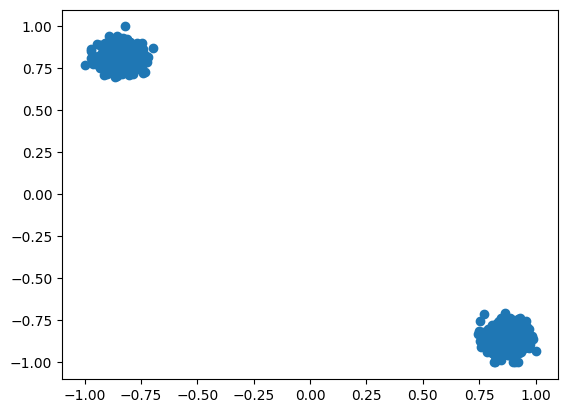

In [7]:
plt.scatter(data[:, 0], data[:, 1])
plt.show()

## Set KL-divergence as metric

We can measure in this example the training performances by using the KL-divergence code provided below.
This will be computed between the original data and the generations from the EBM model.

In [8]:
nbins = 20


@eqx.filter_jit
def estimate_distribution(data, nbbins: int = 10):
    # Use histogram to estimate the probability distribution
    hist, bins = jnp.histogram(data, bins=nbbins, density=True)
    return hist * jnp.diff(bins)


X_dist = estimate_distribution(data, nbins)


@eqx.filter_jit
def compute_KL(gens, eps=1e-17):
    q = estimate_distribution(gens, nbins)
    return X_dist.dot(jnp.log(X_dist + eps) - jnp.log(q + eps))

To get generations out of the model, we set up a Langevin sampler of the size of the data.

In [9]:
sampling_steps = 20
sampling_step_size = 0.1
sigma = 0.01

inits = jax.vmap(lambda x: jax.random.uniform(x, minval=-1, maxval=1, shape=(2,)))(
    jax.random.split(key, 1000)
)
sampler_evaluation = LangevinSampler(
    (2,), 1000, -1.0, 1.0, sampling_step_size, sigma, sampling_steps + 10
)
sample_fn_evaluation = eqx.filter_jit(sampler_evaluation.sample_chains)

## Setup training with Adam optimizer

In [21]:
key, subkey = jax.random.split(key, 2)
ebm = ContinuousNNEBM(nns.MLP(dims=2, depth=3, width=10, key=subkey))

epochs = 50  # 50
batch_size = 64

sampler = LangevinSampler(
    (2,), batch_size, -1, 1, sampling_step_size, sigma, sampling_steps
)
sample_fn = eqx.filter_jit(sampler.sample_chains)

regularization = 0
optimizer = optax.adam(learning_rate=0.1)
opt_state = optimizer.init(eqx.filter(ebm, eqx.is_array))

loss_grad = eqx.filter_value_and_grad(contrastive_divergence)

ndata = len(data)


@eqx.filter_jit
def step(optimizer_ebm, mlp, real_batch, fake_batch, opt_state):
    lossval, grads = loss_grad(mlp, real_batch, fake_batch, regularization)
    updates, opt_state = optimizer_ebm.update(grads, opt_state, mlp)
    mlp = eqx.apply_updates(mlp, updates)
    return mlp, opt_state, lossval


@eqx.filter_jit
def inner_loop(key, optimizer_ebm, ebm, opt_state):
    # get real data
    key, subkey = jax.random.split(key, 2)
    inds = jax.random.randint(subkey, minval=0, maxval=ndata, shape=(batch_size,))
    real_batch = data[inds]

    # get generations from EBM
    key, subkey = jax.random.split(key, 2)
    fake_batch = jax.lax.stop_gradient(sample_fn(ebm, None, subkey))["position"]

    # update EBM
    ebm, opt_state, lossval = step(
        optimizer_ebm, ebm, real_batch, fake_batch, opt_state
    )

    return key, ebm, opt_state, lossval

In [22]:
min_KL = 10000.0
current_KL = min_KL
loss_track = []

gensamples_minKL = None
lossval = 0.0
for e in range(epochs):
    if e % 20 == 0:
        print(e, "/", epochs)

    key, ebm, opt_state, lossval_e = inner_loop(key, optimizer, ebm, opt_state)
    lossval += lossval_e
    loss_track.append(lossval / (e + 1))

    samples_models = sample_fn_evaluation(ebm, inits, key)["position"]

    current_KL = compute_KL(samples_models)

    if current_KL < min_KL:
        min_KL = current_KL
        gensamples_minKL = jnp.copy(samples_models)

0 / 50
20 / 50
40 / 50


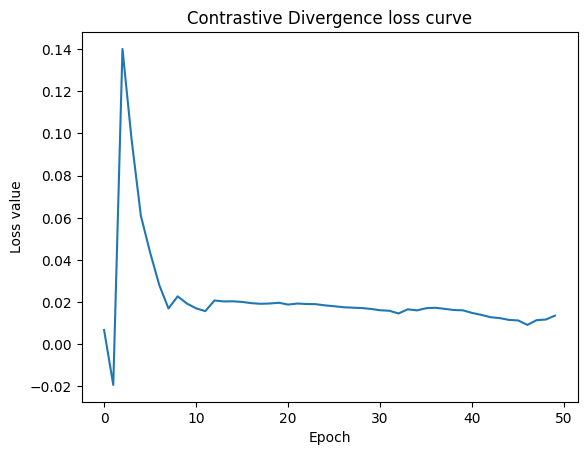

In [23]:
plt.plot(loss_track)
plt.title("Contrastive Divergence loss curve")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.show()

## Show generations from EBM

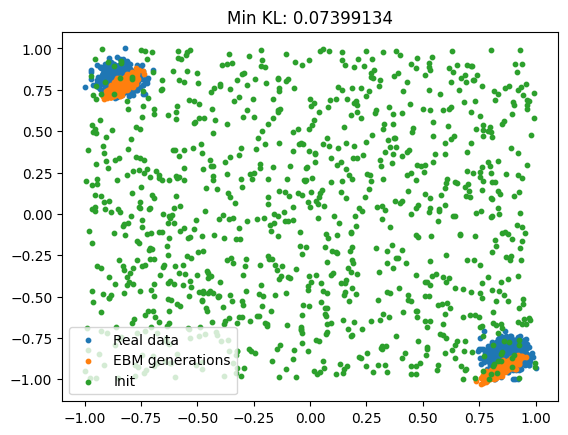

In [24]:
plt.scatter(data[:, 0], data[:, 1], label="Real data", s=10)
plt.scatter(
    gensamples_minKL[:, 0], gensamples_minKL[:, 1], label="EBM generations", s=10
)
plt.scatter(inits[:, 0], inits[:, 1], label="Init", s=10)
plt.legend()
plt.title("Min KL: " + str(min_KL))
plt.show()

## Try a different optimizer

We also have other optimizers that can yield better results with EBMs. Here we use a Stochastic Gradient Langevin Dynamics (SGLD) optimizer. Let us retrain a model with it. 

In [25]:
from energax.optimizers import sgld

In [26]:
key = jax.random.PRNGKey(42)

key, subkey = jax.random.split(key, 2)
ebm2 = ContinuousNNEBM(nns.MLP(dims=2, depth=3, width=10, key=subkey))

# Note the scale factor in the SGLD formula one require to multiply the learning rate
# by a scale_factor of -N/2
optimizer2 = sgld(
    learning_rate=0.01, scale_factor=-0.5 * 1000, use_preconditioning=True, momentum=0.9
)
opt_state2 = optimizer2.init(eqx.filter(ebm2, eqx.is_array))

In [27]:
min_KL = 10000.0
current_KL = min_KL
loss_track = []

gensamples_minKL = None
lossval = 0.0
for e in range(epochs):
    if e % 20 == 0:
        print(e, "/", epochs)

    key, ebm2, opt_state2, lossval_e = inner_loop(key, optimizer2, ebm, opt_state2)
    lossval += lossval_e
    loss_track.append(lossval / (e + 1))

    samples_models = sample_fn_evaluation(ebm2, inits, key)["position"]
    current_KL = compute_KL(samples_models)

    if current_KL < min_KL:
        min_KL = current_KL
        gensamples_minKL = jnp.copy(samples_models)

0 / 50
20 / 50
40 / 50


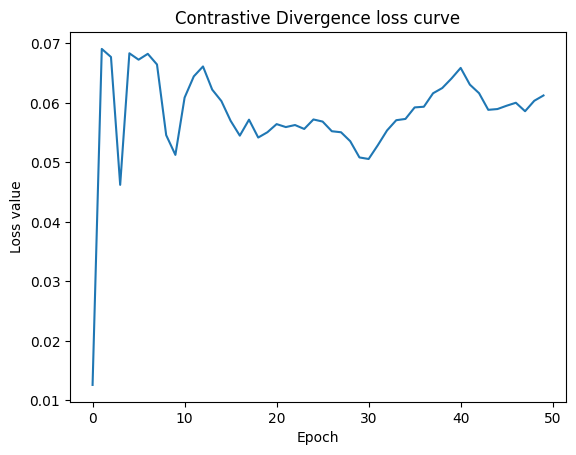

In [28]:
# We get lower KL in this case but this is can be subject to many

plt.plot(loss_track)
plt.title("Contrastive Divergence loss curve")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.show()

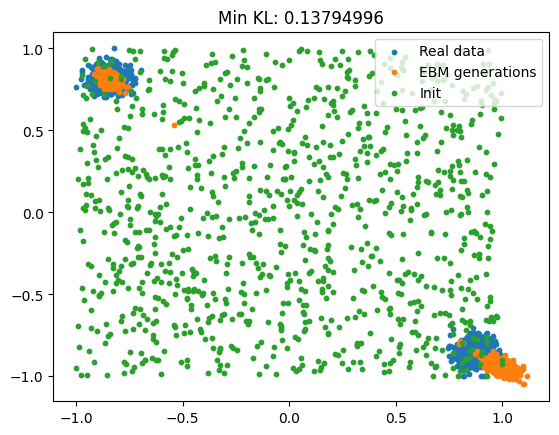

In [29]:
plt.scatter(data[:, 0], data[:, 1], label="Real data", s=10)
plt.scatter(
    gensamples_minKL[:, 0], gensamples_minKL[:, 1], label="EBM generations", s=10
)
plt.scatter(inits[:, 0], inits[:, 1], label="Init", s=10)
plt.legend()
plt.title("Min KL: " + str(min_KL))
plt.show()